# Pix2Pix GAN

논문 : Image-to-Image Translation with Conditional Adversarial Networks (https://arxiv.org/abs/1611.07004)  
code 참조 : 
- https://github.com/eriklindernoren/PyTorch-GAN
- https://github.com/mrzhu-cool/pix2pix-pytorch/tree/master/dataset


In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.cuda import is_available
from torch.nn.modules.batchnorm import BatchNorm2d
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms.functional import to_pil_image
import os
from os import listdir
from os.path import join

In [2]:
torch.manual_seed(0)


In [3]:
device='cuda' if is_available() else 'cpu'

## Generator
Pix2Pix GAN에선 U-Net 구조의 Generator를 사용했다.

- LeakyReLU slope : 0.2
- convolution filter size : 4x4
- stride : 2
- decoder의 activation은 ReLU를 사용한다.
- 마지막 layer에선 Tanh함수 사용한다.
- first C64에선 BatchNorm을 적용하지 않는다.
- dropout rate of 50%
- decoder에서 마지막에 upsample by a factor of 2

encoder

In [4]:
class UNetDown(nn.Module):
  def __init__ (self, in_dim= 3, out_dim = 3,norm = True, dropout = 0.0,filter_size = 4,stride=2,padding = 1): 
    #이 논문에선 Droupout를 적용함
    super(UNetDown,self).__init__()
    layers = [nn.Conv2d(in_dim, out_dim,filter_size,stride=stride,padding = padding,bias = False)]
    if norm:
      layers.append(nn.InstanceNorm2d(out_dim))
    if dropout:
      layers.append(nn.Dropout(dropout))
    layers.append(nn.LeakyReLU(0.2))
    self.down = nn.Sequential(*layers)
  def forward(self,x):
    x = self.down(x)
    return x

decoder


In [5]:
class UNetUp(nn.Module):
  def __init__ (self, in_dim= 3, out_dim = 3,norm = True, dropout = 0.0,filter_size = 4,stride=2,padding = 1): 
    #이 논문에선 Droupout를 적용함
    super(UNetUp,self).__init__()
    layers = [nn.ConvTranspose2d(in_dim, out_dim,filter_size,stride=stride,padding = padding,bias = False)]
    if norm:
      layers.append(nn.InstanceNorm2d(out_dim))
    if dropout:
      layers.append(nn.Dropout(dropout))
    layers.append(nn.ReLU(inplace = True))
    self.model = nn.Sequential(*layers)
  def forward(self,x, skip_input):
    x = self.model(x)
    x = torch.cat((x,skip_input),1) #skip connection
    return x

- encoder : C64-C128-C256-C512-C512-C512-C512-C512
- decoder:
CD512-CD512-CD512-C512-C256-C128-C64
- U-Net decoder:
CD512-CD1024-CD1024-C1024-C1024-C512 -C256-C128

C : [ Convolution-BatchNorm-ReLU]  
CD : [ Convolution-BatchNormDropout-ReLU]

In [6]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_dim=3, out_dim=3):
        super(GeneratorUNet, self).__init__()
        self.down1 = UNetDown(in_dim, 64, norm=False) #256
        self.down2 = UNetDown(64, 128) #128
        self.down3 = UNetDown(128, 256) #64
        self.down4 = UNetDown(256, 512, dropout=0.5) #32
        self.down5 = UNetDown(512, 512, dropout=0.5) #16
        self.down6 = UNetDown(512, 512, dropout=0.5) #8
        self.down7 = UNetDown(512, 512, dropout=0.5) #4
        self.down8 = UNetDown(512, 512, norm=False, dropout=0.5) #1

        self.up1 = UNetUp(512, 512, dropout=0.5) 
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),#mode : nearest
            # zero padding :padding_left, \padding_right, \padding_top, \padding_bottom
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_dim, 4, padding=1),
            nn.Tanh(),
        )
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


## Discriminator
Discriminator는 PatchGAN 구조를 사용했다.

- downsample by a factor of 2

In [7]:
class discriminator_block(nn.Module):
  def __init__(self,in_dim= 3, out_dim = 3,norm = True, dropout = 0.0,stride=2,padding = 1):
    super(discriminator_block,self).__init__()
    #return downsampling layers of each discriminator block
    layers = [nn.Conv2d(in_dim,out_dim,4,stride=stride,padding=padding)]
    if norm:
      layers.append(nn.InstanceNorm2d(out_dim))
    layers.append(nn.LeakyReLU(0.2,inplace=True))
    
    self.block= nn.Sequential(*layers)
  def forward(self,x):
    x = self.block(x)
    return x

In [8]:
class PatchDiscriminator(nn.Module):
  def __init__(self,in_dim=3):
    super(PatchDiscriminator,self).__init__()
    self.disc_blk1 = discriminator_block(in_dim*2,64,norm=False)
    self.disc_blk2 = discriminator_block(64,128)
    self.disc_blk3 = discriminator_block(128,256)
    self.disc_blk4 = discriminator_block(256,512)
    self.model = nn.Sequential(
        nn.ZeroPad2d((1,0,1,0)),
        nn.Conv2d(512,1,4,padding=1,bias=False)
    )
  
  def forward(self,img_A,img_B):
    x = torch.cat((img_A,img_B),1)
    x = self.disc_blk1(x)
    x = self.disc_blk2(x)
    x = self.disc_blk3(x)
    x = self.disc_blk4(x)
    x = self.model(x)
    return F.sigmoid(x) #이 부분은 논란이 있다. 
     # 저자의 공식 Git Hub 이슈 페이지 : https://github.com/phillipi/pix2pix/issues/120
  
    

## facade dataset 받기

In [9]:
!git clone https://github.com/mrzhu-cool/pix2pix-pytorch # 깃 클론
!mkdir 'data' # 폴더 생성
!unzip /content/pix2pix-pytorch/dataset/facades.zip  -d /content/data;

Cloning into 'pix2pix-pytorch'...
remote: Enumerating objects: 68, done.
remote: Total 68 (delta 0), reused 0 (delta 0), pack-reused 68
Unpacking objects: 100% (68/68), done.
Archive:  /content/pix2pix-pytorch/dataset/facades.zip
   creating: /content/data/facades/
   creating: /content/data/facades/test/
   creating: /content/data/facades/test/a/
  inflating: /content/data/facades/test/a/cmp_b0001.png  
  inflating: /content/data/facades/test/a/cmp_b0002.png  
  inflating: /content/data/facades/test/a/cmp_b0003.png  
  inflating: /content/data/facades/test/a/cmp_b0004.png  
  inflating: /content/data/facades/test/a/cmp_b0013.png  
  inflating: /content/data/facades/test/a/cmp_b0023.png  
  inflating: /content/data/facades/test/a/cmp_b0026.png  
  inflating: /content/data/facades/test/a/cmp_b0028.png  
  inflating: /content/data/facades/test/a/cmp_b0034.png  
  inflating: /content/data/facades/test/a/cmp_b0035.png  
  inflating: /content/data/facades/test/a/cmp_b0047.png  
  inflating:

In [10]:
class CustomDataset(Dataset):
  def __init__(self,path2img,direction='b2a',transform=None):
    super().__init__()
    self.direction = direction
    self.path2a = join(path2img,'a')
    self.path2b = join(path2img,'b')
    self.img_filenames = [x for x in listdir(self.path2a)]
    self.transform = transform
  def __getitem__(self,index):
    #input image
    a = Image.open(join(self.path2a, self.img_filenames[index])).convert('RGB')
    #output image
    b = Image.open(join(self.path2b, self.img_filenames[index])).convert('RGB')
    if self.transform is not None:
      a = self.transform(a)
      b = self.transform(b)
    if self.direction == 'b2a':
      return b,a
    else :
      return a,b
  def __len__(self):
    return len(self.img_filenames)



In [11]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
                    transforms.Resize((256,256))
])

In [12]:
# 데이터셋 불러오기
path2img = '/content/data/facades/train'
train_dataset = CustomDataset(path2img, transform=transform)

(-0.5, 255.5, 255.5, -0.5)

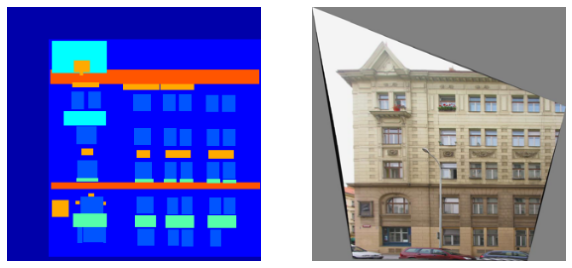

In [13]:
# 샘플 이미지 확인하기

a,b = train_dataset[0]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(0.5*a+0.5))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(0.5*b+0.5))
plt.axis('off')

dataloader

In [14]:
dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True)


## 학습

In [15]:
gen = GeneratorUNet().to(device)
disc = PatchDiscriminator().to(device)

In [16]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [17]:
# 손실함수
criterion_gan = nn.BCELoss().to(device)
criterion_pix = nn.L1Loss().to(device)
# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100
# patch 수
patch = (1,256//2**4,256//2**4)

gen_opt = torch.optim.Adam(gen.parameters(),lr=0.0002,betas=(0.5,0.999))
disc_opt = torch.optim.Adam(disc.parameters(),lr=0.0002,betas=(0.5,0.999))


In [18]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 256, 256), nrow=5, show=True):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

In [22]:
from tqdm import tqdm_notebook
gen.train()
disc.train()

cur_step = 0
n_epochs=100
display_step = 200
g_losses = []
d_losses = []

for epoch in tqdm_notebook(range(n_epochs),desc="Training :"):
    for input, output in tqdm_notebook(dataloader,leave=False):
        cur_batch_size = len(input)
        real_input = input.to(device)
        real_output = output.to(device)
        #patch label
        real_label = torch.ones(cur_batch_size,*patch,requires_grad=False).to(device)  
        fake_label = torch.zeros(cur_batch_size,*patch,requires_grad=False).to(device)
      
        #update generator
        gen_opt.zero_grad()
        fake = gen(real_input)
        disc_fake_pred = disc(fake,real_output)
        gen_loss = criterion_gan(disc_fake_pred,real_label)
        pix_loss = criterion_pix(fake,real_output)
        
        g_loss = (gen_loss+pix_loss*lambda_pixel)
        g_loss.backward()
        gen_opt.step()
        g_losses.append(g_loss)
        # update discriminator
        disc_opt.zero_grad()

        disc_real_pred = disc(real_output,real_input)
        disc_real_loss = criterion_gan(disc_real_pred,real_label)

        disc_fake_pred = disc(fake.detach(),real_input)
        disc_fake_loss = criterion_gan(disc_fake_pred,fake_label)
        
        d_loss = (disc_real_loss+disc_fake_loss)/2.
        d_loss.backward()
        disc_opt.step()
        d_losses.append(d_loss)

        # Visualization code
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(g_losses[-display_step:]) / display_step
            crit_mean = sum(d_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(real_input)
            show_tensor_images(fake)
            show_tensor_images(real_output)
            step_bins = 20
            num_examples = (len(g_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(g_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(d_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1

Output hidden; open in https://colab.research.google.com to view.

테스트

In [36]:
path2img = '/content/data/facades/test'
test_dataset = CustomDataset(path2img, transform=transform)
test_dataloader = DataLoader(test_dataset,batch_size=16)

(-0.5, 255.5, 255.5, -0.5)

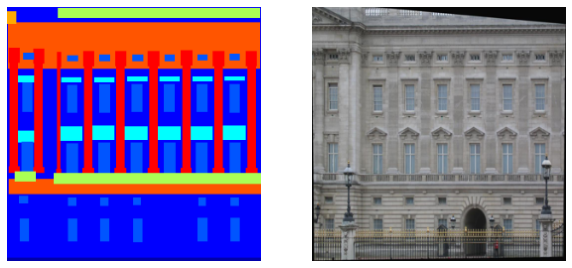

In [37]:
# 샘플 이미지 확인하기
a,b = test_dataset[0]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(0.5*a+0.5))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(0.5*b+0.5))
plt.axis('off')

In [41]:
gen.eval()
with torch.no_grad():
    for a,b in test_dataloader:
        fake_imgs = gen(a.to(device)).detach().cpu()
        real_imgs = b
        break

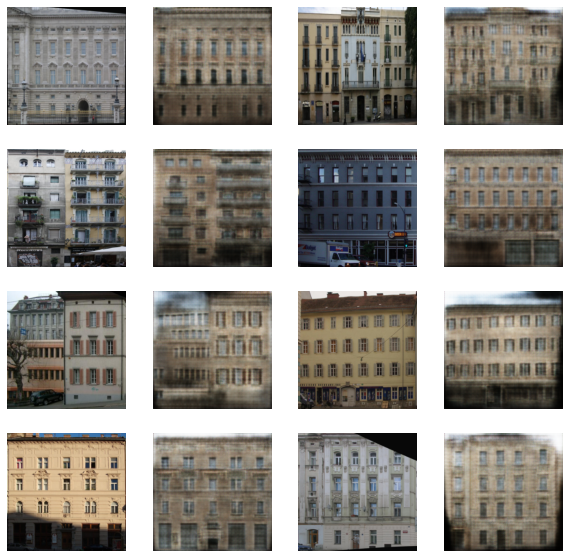

In [42]:
plt.figure(figsize=(10,10))

for ii in range(0,16,2):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*real_imgs[ii]+0.5))
    plt.axis('off')
    plt.subplot(4,4,ii+2)
    plt.imshow(to_pil_image(0.5*fake_imgs[ii]+0.5))
    plt.axis('off')